## Task f : Define a strategy to represent text data (e.g., feature extraction/engineering)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import torch
from transformers import BertModel, BertTokenizer


/ghome/group04/anaconda3/envs/cvc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocess pickle files and Tokenization 

In [2]:
folder_path = "/ghome/group04/MCV-C5-G4/First_Impressions_v3_multimodal"

preprocess_folder = "/ghome/group04/MCV-C5-G4/week6/task_f"

directories = {"train": "train", "valid": "valid", "test": "test"}

for directory, subdir in directories.items():

    directory_path = os.path.join(folder_path, subdir)
    output_file = os.path.join(preprocess_folder, f"preprocessed_text_{directory}.txt")
    os.makedirs(preprocess_folder, exist_ok=True)

    with open(output_file, "w") as output:
        if not os.path.exists(directory_path):
            print(f"Directory {directory_path} does not exist.")
            continue

        for item in os.listdir(directory_path):
            item_path = os.path.join(directory_path, item)

            if os.path.isdir(item_path):
                output.write(f"Processing folder {item} in {directory} directory:\n")

                for file_name in os.listdir(item_path):
                    if file_name.endswith(".pkl"):
                        file_path = os.path.join(item_path, file_name)

                        with open(file_path, "rb") as f:
                            try:
                                transcription = pickle.load(f)
                            except Exception as e:
                                print(f"Error loading pickle file {file_path}: {e}")
                                continue

                            transcription = transcription.lower()
                            transcription = ''.join(e for e in transcription if e.isalnum() or e.isspace())
                            
                            output.write(f"File: {file_name}\n")
                            output.write(f"Preprocessed Transcription: {transcription}\n")

                output.write("\n")  


## Represent text data using BoW and BERT

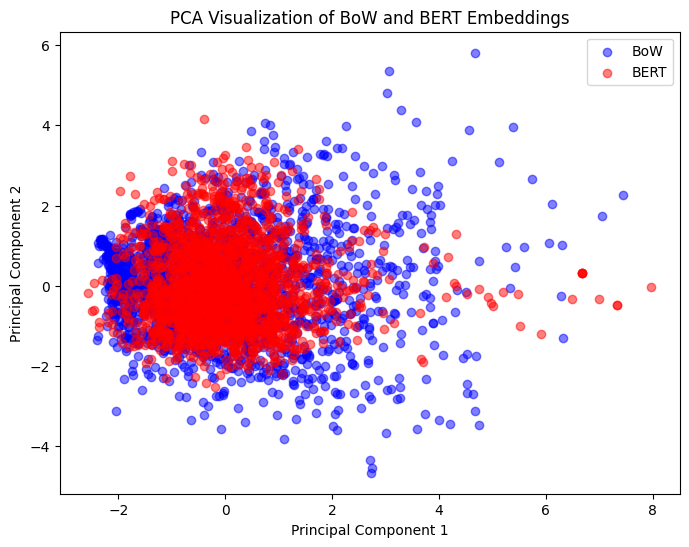

In [8]:
file_path = "/ghome/group04/MCV-C5-G4/week6/task_f/preprocessed_text_test.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

# extract transcriptions 
transcriptions = []
for line in lines:
    if line.startswith("Preprocessed Transcription:"):
        transcription = line[len("Preprocessed Transcription:"):].strip()
        transcriptions.append(transcription)

# create bow representation
vectorizer = CountVectorizer()
bag_of_words_representation = vectorizer.fit_transform(transcriptions)

# apply PCA to reduce dimensions for visualization
pca_bow = PCA(n_components=2)
bow_pca = pca_bow.fit_transform(bag_of_words_representation.toarray())

# plot PCA-transformed representations for BoW
plt.figure(figsize=(8, 6))
plt.scatter(bow_pca[:, 0], bow_pca[:, 1], alpha=0.5, label="BoW", color='blue')

# load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

embeddings = []

for line in lines:
    if line.startswith("Preprocessed Transcription:"):
        text = line[len("Preprocessed Transcription:"):].strip()

        # tokenize the text
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        
        # get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state

            # average pooling of embeddings
            avg_pooling = torch.mean(last_hidden_state, dim=1).squeeze()

            # convert tensor to numpy array
            embedding = avg_pooling.numpy()

            # append embedding to list
            embeddings.append(embedding)

# Convert list of embeddings to numpy array
embeddings = np.array(embeddings)

# Apply PCA to reduce dimensions for visualization
pca_bert = PCA(n_components=2)
bert_pca = pca_bert.fit_transform(embeddings)

# plot PCA-transformed representations for BERT
plt.scatter(bert_pca[:, 0], bert_pca[:, 1], alpha=0.5, label="BERT", color='red')
plt.title("PCA Visualization of BoW and BERT Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


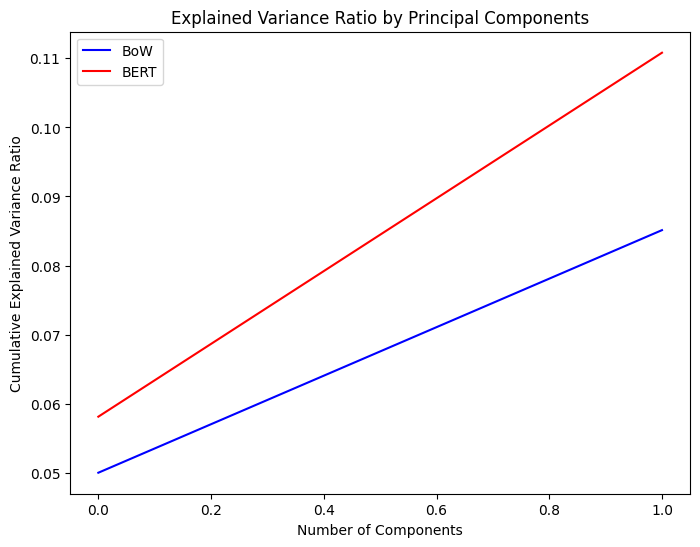

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_bow.explained_variance_ratio_), label="BoW", color='blue')
plt.plot(np.cumsum(pca_bert.explained_variance_ratio_), label="BERT", color='red')
plt.title("Explained Variance Ratio by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.legend()
plt.show()